In [1]:
import pandas as pd
import numpy as np
from utils import reduction_function as rfun
from utils import polarization_function as pfun
import networkx as nx

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
net_file = pd.read_csv("../output_network/network_filtered.csv", sep="\t")
G = nx.from_pandas_edgelist(net_file, "src", "trg")
print(G)

Graph with 511 nodes and 2785 edges


## Loading the labelled message files

In [3]:
import csv

In [4]:
abortion_df = pd.read_csv("../llama_probs/llama_probabilities_full_abortion.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)
marriage_df = pd.read_csv("../llama_probs/llama_probabilities_full_marriage.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)
political_df = pd.read_csv("../llama_probs/llama_probabilities_full_political.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)

In [5]:
abortion_df.shape, marriage_df.shape, political_df.shape

((19939, 13), (13073, 13), (25360, 13))

In [6]:
abortion_df = abortion_df[["user", "text", "topic", "A", "F", "N"]]
marriage_df = marriage_df[["user", "text", "topic", "A", "F", "N"]]
political_df = political_df[["user", "text", "topic", "A", "F", "N"]]
political_df.head()

,user,text,topic,A,F,N
0,InterestingCry1789,"""""""You asked why your views make you right lea...",1,0.000000,0.000000,0.000000
1,truEarth_,"""""""I wouldn't call them the """"""""left"""""""". Pros...",1,0.000000,0.000000,0.000000
2,SomeHomo69,You're not a libertarian,1,0.142808,0.071656,0.000000
3,kevinr_96,That makes sense. Could you elaborate on the l...,1,0.000000,0.193313,0.806687
4,sohmeho,Fuck liberals.,1,1.000000,0.000000,0.000000


In [7]:
political_df[(political_df["A"] == 0.0) & (political_df["F"] == 0.0) & (political_df["N"] == 0.0)]

,user,text,topic,A,F,N
0,InterestingCry1789,"""""""You asked why your views make you right lea...",1,0.0,0.0,0.0
1,truEarth_,"""""""I wouldn't call them the """"""""left"""""""". Pros...",1,0.0,0.0,0.0
5,hufreema,"""""""Conservatism isn't rigid, it's just slow. I...",1,0.0,0.0,0.0
8,insensitiveTwot,This is a problem I have with conservatives. Y...,1,0.0,0.0,0.0
15,otarru,"I did say further left than Podemos, as in peo...",1,0.0,0.0,0.0
...,...,...,...,...,...,...
25344,-_AirBuddDwyer_-,"Liberals care more about order than justice, t...",1,0.0,0.0,0.0
25355,Brycekaz,Like the far right calling the moderate right ...,1,0.0,0.0,0.0
25356,TheLongestLake,""""""" I dont want to say the overall conclusions...",1,0.0,0.0,0.0
25357,Justacha,Because I want every individual to be free to...,1,0.0,0.0,0.0


Checking that users are in the graph G

In [8]:
user_nodeid = pd.read_csv("../reddit_22_51/user_nodeid.csv", sep="\t")
user_nodeid_dict = user_nodeid.set_index('index')['nodeid'].to_dict()
abortion_df['nodeid'] = abortion_df['user'].map(user_nodeid_dict) #mapping usernames to node ids
marriage_df['nodeid'] = marriage_df['user'].map(user_nodeid_dict)
political_df['nodeid'] = political_df['user'].map(user_nodeid_dict)

In [9]:
abortion_df_filtered = abortion_df[abortion_df['nodeid'].isin(G.nodes())] #filtering the users to be only those who wrote in all 3 topics (those form the graph)
marriage_df_filtered = marriage_df[marriage_df['nodeid'].isin(G.nodes())]
political_df_filtered = political_df[political_df['nodeid'].isin(G.nodes())]

### Selecting and averaging the stance probabilities 

In [10]:
abortion_df_avg = rfun.get_avg(abortion_df_filtered, "abortion") #getting the stance (from -1 to 1) from the probability
marriage_df_avg = rfun.get_avg(marriage_df_filtered, "marriage")
political_df_avg = rfun.get_avg(political_df_filtered, "political")

In [11]:
marriage_df_avg.shape

(511, 5)

In [12]:
merged_df = rfun.merge_datasets(abortion_df_avg, marriage_df_avg, political_df_avg)
merged_df.shape

(511, 13)

UMAP and PCA on the simulated data

In [13]:
merged_df.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political
0,-_AirBuddDwyer_-,0.000000,0.000000,1.000000,0.000000,0.389795,0.314452,0.095753,0.389795,0.199448,0.231097,0.035146,-0.231097
1,0m4ll3y,0.000000,0.060795,0.939205,-0.060795,0.000000,0.000000,1.000000,0.000000,0.000000,0.314424,0.000000,-0.314424
2,3720-To-One,0.000000,1.000000,0.000000,-1.000000,0.370153,0.375505,0.254343,-0.375505,0.084279,0.737476,0.051336,-0.737476
3,5eggsEveryday,0.541052,0.140086,0.181419,0.541052,1.000000,0.000000,0.000000,1.000000,0.000000,0.223798,0.000000,-0.223798
4,ABobby077,0.237265,0.000000,0.000000,0.237265,0.488284,0.511716,0.000000,-0.511716,1.000000,0.000000,0.000000,1.000000


In [14]:
merged_df_reduced = rfun.apply_pca(merged_df, ["stance_political", "stance_abortion", "stance_marriage"])
merged_df_reduced = rfun.apply_umap(merged_df, ["stance_political", "stance_abortion", "stance_marriage"])

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
merged_df_reduced.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political,pca_component,umap_component
0,-_AirBuddDwyer_-,0.000000,0.000000,1.000000,-0.115395,0.389795,0.314452,0.095753,0.529918,0.199448,0.231097,0.035146,-0.299616,0.244310,2.331976
1,0m4ll3y,0.000000,0.060795,0.939205,-0.219076,0.000000,0.000000,1.000000,-0.156291,0.000000,0.314424,0.000000,-0.502582,-0.336665,7.484731
2,3720-To-One,0.000000,1.000000,0.000000,-1.820800,0.370153,0.375505,0.254343,-0.817342,0.084279,0.737476,0.051336,-1.533041,-2.073131,13.627132
3,5eggsEveryday,0.541052,0.140086,0.181419,0.807317,1.000000,0.000000,0.000000,1.604144,0.000000,0.223798,0.000000,-0.281838,1.643231,-6.041427
4,ABobby077,0.237265,0.000000,0.000000,0.289238,0.488284,0.511716,0.000000,-1.057132,1.000000,0.000000,0.000000,2.699056,-0.136593,16.846977


#### Saving the user scores in the format needed for the polaization code 

In [16]:
merged_df_reduced['nodeid'] = merged_df_reduced['user'].map(user_nodeid_dict) #mapping usernames to node ids

In [17]:
merged_df_reduced.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political,pca_component,umap_component,nodeid
0,-_AirBuddDwyer_-,0.000000,0.000000,1.000000,-0.115395,0.389795,0.314452,0.095753,0.529918,0.199448,0.231097,0.035146,-0.299616,0.244310,2.331976,1232857
1,0m4ll3y,0.000000,0.060795,0.939205,-0.219076,0.000000,0.000000,1.000000,-0.156291,0.000000,0.314424,0.000000,-0.502582,-0.336665,7.484731,310655
2,3720-To-One,0.000000,1.000000,0.000000,-1.820800,0.370153,0.375505,0.254343,-0.817342,0.084279,0.737476,0.051336,-1.533041,-2.073131,13.627132,614035
3,5eggsEveryday,0.541052,0.140086,0.181419,0.807317,1.000000,0.000000,0.000000,1.604144,0.000000,0.223798,0.000000,-0.281838,1.643231,-6.041427,1231148
4,ABobby077,0.237265,0.000000,0.000000,0.289238,0.488284,0.511716,0.000000,-1.057132,1.000000,0.000000,0.000000,2.699056,-0.136593,16.846977,607299


In [18]:
merged_df_reduced["nodeid"]

0      1232857
1       310655
2       614035
3      1231148
4       607299
        ...   
506     715228
507    1211120
508     207263
509     972135
510     153573
Name: nodeid, Length: 511, dtype: int64

##### Polarization code 

In [19]:
pfun.calc_pol4(G, merged_df_reduced, "pca_component")

               user       A_x       F_x       N_x  stance_abortion       A_y  \
0  -_AirBuddDwyer_-  0.000000  0.000000  1.000000        -0.115395  0.389795   
1           0m4ll3y  0.000000  0.060795  0.939205        -0.219076  0.000000   
2       3720-To-One  0.000000  1.000000  0.000000        -1.820800  0.370153   
3     5eggsEveryday  0.541052  0.140086  0.181419         0.807317  1.000000   
4         ABobby077  0.237265  0.000000  0.000000         0.289238  0.488284   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.314452  0.095753         0.529918  0.199448  0.231097  0.035146   
1  0.000000  1.000000        -0.156291  0.000000  0.314424  0.000000   
2  0.375505  0.254343        -0.817342  0.084279  0.737476  0.051336   
3  0.000000  0.000000         1.604144  0.000000  0.223798  0.000000   
4  0.511716  0.000000        -1.057132  1.000000  0.000000  0.000000   

   stance_political  pca_component  umap_component   nodeid  
0         -0.299616     

np.float64(16.016326801400805)

In [20]:
pfun.calc_pol4(G, merged_df_reduced, "umap_component")

               user       A_x       F_x       N_x  stance_abortion       A_y  \
0  -_AirBuddDwyer_-  0.000000  0.000000  1.000000        -0.115395  0.389795   
1           0m4ll3y  0.000000  0.060795  0.939205        -0.219076  0.000000   
2       3720-To-One  0.000000  1.000000  0.000000        -1.820800  0.370153   
3     5eggsEveryday  0.541052  0.140086  0.181419         0.807317  1.000000   
4         ABobby077  0.237265  0.000000  0.000000         0.289238  0.488284   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.314452  0.095753         0.529918  0.199448  0.231097  0.035146   
1  0.000000  1.000000        -0.156291  0.000000  0.314424  0.000000   
2  0.375505  0.254343        -0.817342  0.084279  0.737476  0.051336   
3  0.000000  0.000000         1.604144  0.000000  0.223798  0.000000   
4  0.511716  0.000000        -1.057132  1.000000  0.000000  0.000000   

   stance_political  pca_component  umap_component   nodeid  
0         -0.299616     

np.float64(122.7106893033029)

### Results:
Polarization on the PCA component: 16.697074410642806

Polarization on the UMAP component: 119.47712444892863

Some plots of the network:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
 
def plot_c_subplot(merged_df, pc_column, color_topics):
    num_plots = len(color_topics)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)
 
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one plot
 
    for i, (color_topic, ax) in enumerate(zip(color_topics, axes)):
        num_users = merged_df.shape[0]
        y_axis = np.random.rand(num_users)
 
        scatter = ax.scatter(merged_df[pc_column], y_axis, c=merged_df[color_topic], cmap='coolwarm')
        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label(f'{color_topic} stance')
 
        ax.set_xlabel('UMAP component' if pc_column == "umap_component" else 'Principal component')
        if i == 0:
            ax.set_ylabel('Random')  # Label only on first plot
        ax.set_title(f'Scatter plot - {color_topic}')
 
    plt.tight_layout()
    plt.show()

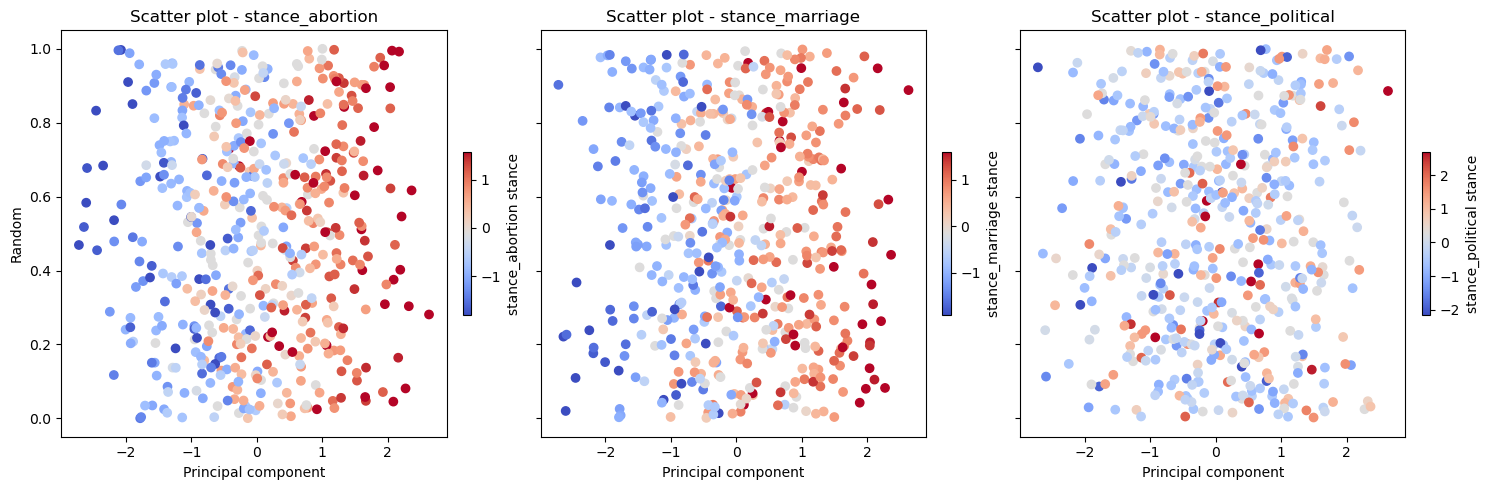

In [22]:
plot_c_subplot(merged_df_reduced, "pca_component", ["stance_abortion", "stance_marriage", "stance_political"])

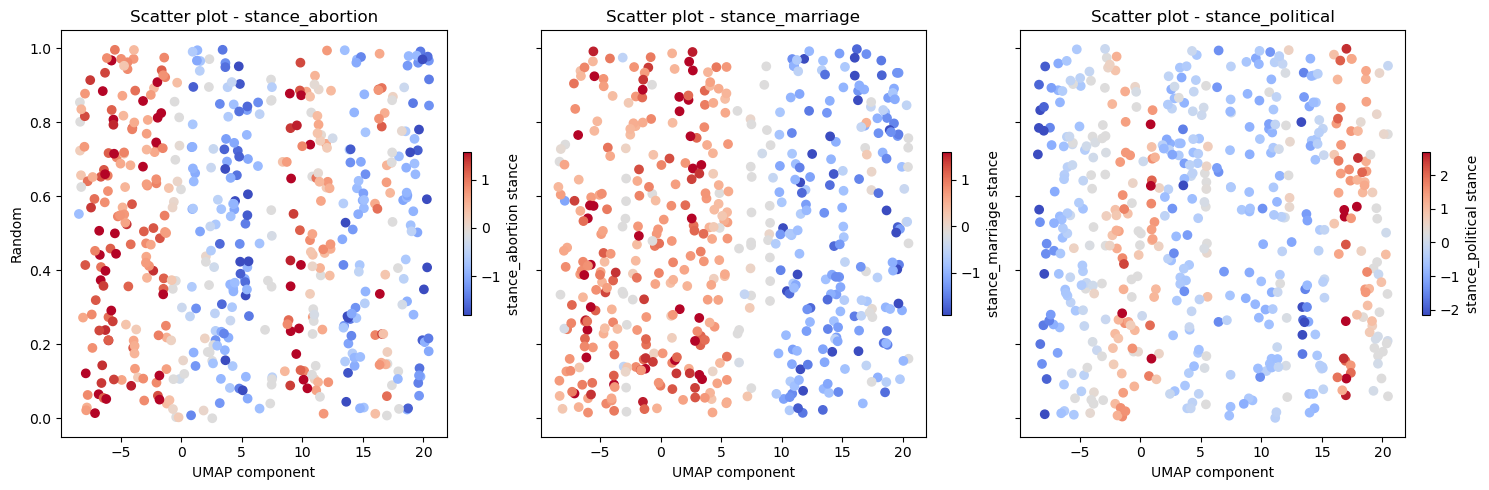

In [23]:
plot_c_subplot(merged_df_reduced, "umap_component", ["stance_abortion", "stance_marriage", "stance_political"])

Dividing pca scores by 2 to get them between -1 and 1 

In [26]:
merged_df_reduced["pca_component_scaled"] = merged_df_reduced["pca_component"]/2

In [29]:
# polarization 
pfun.calc_pol4(G, merged_df_reduced, "pca_component_scaled")

               user       A_x       F_x       N_x  stance_abortion       A_y  \
0  -_AirBuddDwyer_-  0.000000  0.000000  1.000000        -0.115395  0.389795   
1           0m4ll3y  0.000000  0.060795  0.939205        -0.219076  0.000000   
2       3720-To-One  0.000000  1.000000  0.000000        -1.820800  0.370153   
3     5eggsEveryday  0.541052  0.140086  0.181419         0.807317  1.000000   
4         ABobby077  0.237265  0.000000  0.000000         0.289238  0.488284   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.314452  0.095753         0.529918  0.199448  0.231097  0.035146   
1  0.000000  1.000000        -0.156291  0.000000  0.314424  0.000000   
2  0.375505  0.254343        -0.817342  0.084279  0.737476  0.051336   
3  0.000000  0.000000         1.604144  0.000000  0.223798  0.000000   
4  0.511716  0.000000        -1.057132  1.000000  0.000000  0.000000   

   stance_political  pca_component  umap_component   nodeid  \
0         -0.299616    

np.float64(8.008163400700402)

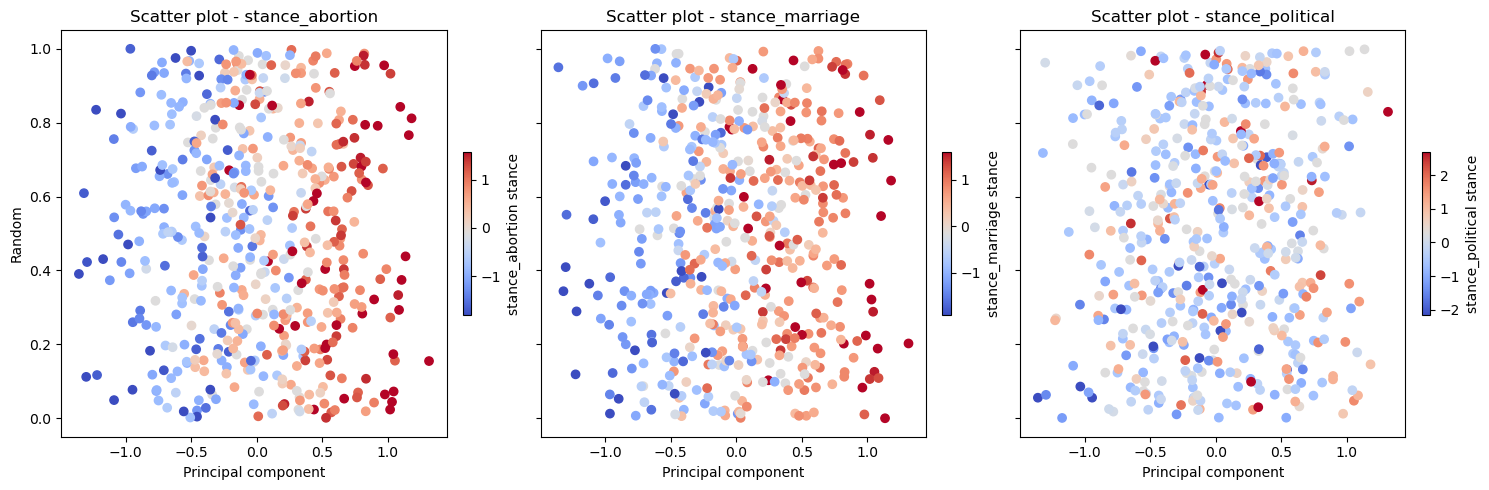

In [28]:
plot_c_subplot(merged_df_reduced, "pca_component_scaled", ["stance_abortion", "stance_marriage", "stance_political"])